# CSE5280 – Floor Plan Penalty Functions

This notebook implements several wall penalty formulations for navigation in a 2D floor plan using **gradient descent on a cost field**.

**Goal:** move a point from a start to a goal while avoiding wall crossings by minimizing

$$
\begin{align}
C(x) &= C_{goal}(x) + \sum_i w_i C_{wall,i}(x)
\end{align}
$$


We compare **three** wall penalty formulations on the **same** floor plan and start/goal configuration.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# For animations
from matplotlib import animation
from IPython.display import HTML

np.set_printoptions(precision=4, suppress=True)


## 1) Geometry utilities

Walls are line segments \([a,b]\). We need point-to-segment distance and the closest point on the segment.


In [ ]:
def closest_point_on_segment(x, a, b):
    """
    Return the closest point q on segment [a,b] to point x, and the segment parameter t in [0,1].
    """
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    x = np.asarray(x, dtype=float)

    v = b - a
    vv = np.dot(v, v)
    if vv == 0.0:
        return a.copy(), 0.0

    t = np.dot(x - a, v) / vv
    t = np.clip(t, 0.0, 1.0)
    q = a + t * v
    return q, t

def point_to_segment_distance(x, a, b):
    q, _ = closest_point_on_segment(x, a, b)
    return np.linalg.norm(np.asarray(x, dtype=float) - q)


## 2) Floor plans

Pick one of the provided floor plans. (You can add your own by editing `load_floor_plan`.)


In [ ]:
def load_floor_plan(name="baseline"):
    """
    Returns: walls, start, goal
      walls: list of (a,b) where a,b are 2D points
    """
    if name == "baseline":
        # Corridor + corner
        walls = [
            # Outer box
            ((0,0),(10,0)), ((10,0),(10,10)), ((10,10),(0,10)), ((0,10),(0,0)),
            # Inner corridor walls
            ((2,2),(8,2)), ((2,4),(8,4)),
            ((8,4),(8,8)), ((6,8),(8,8)),
            ((6,6),(6,8)),
        ]
        start = np.array([1.0, 1.0])
        goal  = np.array([9.0, 9.0])

    elif name == "zigzag":
        walls = [
            ((0,0),(12,0)), ((12,0),(12,12)), ((12,12),(0,12)), ((0,12),(0,0)),
            ((2,2),(10,2)), ((2,4),(10,4)),
            ((2,4),(2,10)), ((4,2),(4,10)),
            ((4,8),(10,8)), ((6,4),(6,12)),
            ((8,0),(8,8)),
        ]
        start = np.array([1.0, 1.0])
        goal  = np.array([11.0, 11.0])

    elif name == "deadend":
        walls = [
            ((0,0),(12,0)), ((12,0),(12,12)), ((12,12),(0,12)), ((0,12),(0,0)),
            ((2,2),(10,2)), ((2,4),(10,4)),
            ((10,4),(10,10)), ((8,6),(10,6)),  # dead end trap
            ((6,8),(10,8)),
        ]
        start = np.array([1.0, 1.0])
        goal  = np.array([11.0, 11.0])

    elif name == "symmetric":
        walls = [
            ((0,0),(12,0)), ((12,0),(12,12)), ((12,12),(0,12)), ((0,12),(0,0)),
            ((2,2),(10,2)), ((2,10),(10,10)),
            ((2,2),(2,10)), ((10,2),(10,10)),
            ((6,2),(6,10)),  # center wall
        ]
        start = np.array([1.0, 6.0])
        goal  = np.array([11.0, 6.0])

    else:
        raise ValueError(f"Unknown floor plan: {name}")

    walls = [(np.array(a, float), np.array(b, float)) for a,b in walls]
    return walls, start, goal

def plot_floor_plan(walls, start=None, goal=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    for a,b in walls:
        ax.plot([a[0], b[0]],[a[1], b[1]], "k-", linewidth=2)
    if start is not None:
        ax.plot(start[0], start[1], "go", markersize=8, label="Start")
    if goal is not None:
        ax.plot(goal[0], goal[1], "ro", markersize=8, label="Goal")
    ax.set_aspect("equal", "box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    if start is not None or goal is not None:
        ax.legend(loc="best")
    return ax


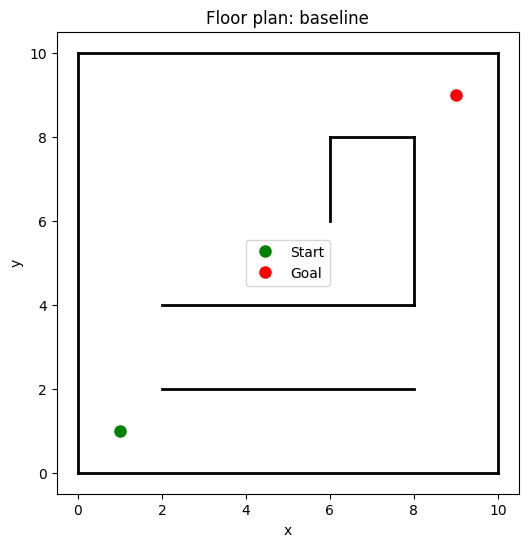

In [ ]:
floor_plan = "baseline"  # change to: "zigzag", "deadend", "symmetric"
walls, start, goal = load_floor_plan(floor_plan)
ax = plot_floor_plan(walls, start, goal)
plt.title(f"Floor plan: {floor_plan}")
plt.show()


## 3) Penalty functions

Each wall contributes a penalty $\phi(d)$
 based on distance \(d\) from the point to the segment.

We implement and compare three formulations:

1. **Quadratic band** (soft wall with radius \(R\))
2. **Truncated inverse-square** (strong repulsion near walls)
3. **Gaussian** (smooth bump around the wall)

All three are truncated so the wall has a finite influence region.


In [ ]:
# ---- 1) Quadratic band ----
def phi_quadratic_band(d, R):
    # 0.5*(R-d)^2 for d<=R else 0
    if d <= R:
        return 0.5 * (R - d)**2
    return 0.0

# ---- 2) Truncated inverse-square ----
def phi_inv_sq(d, R, eps=1e-6):
    # (1/(d+eps)^2 - 1/(R+eps)^2) for d<=R else 0
    if d <= R:
        return (1.0 / (d + eps)**2) - (1.0 / (R + eps)**2)
    return 0.0

# ---- 3) Gaussian ----
def phi_gaussian(d, sigma, R=None):
    # exp(-d^2/(2 sigma^2)) optionally truncated at R
    val = float(np.exp(-(d*d)/(2.0*sigma*sigma)))
    if R is None:
        return val
    return val if d <= R else 0.0

def wall_cost(x, walls, kind, params, weights=None):
    """
    Sum of wall penalties over all segments.
    kind: "quadratic_band" | "inv_sq" | "gaussian"
    params: dict of penalty parameters
    weights: optional list/array of per-wall weights
    """
    x = np.asarray(x, float)
    if weights is None:
        weights = np.ones(len(walls), float)

    total = 0.0
    for (a,b), w in zip(walls, weights):
        d = point_to_segment_distance(x, a, b)
        if kind == "quadratic_band":
            total += w * phi_quadratic_band(d, R=params["R"])
        elif kind == "inv_sq":
            total += w * phi_inv_sq(d, R=params["R"], eps=params.get("eps", 1e-6))
        elif kind == "gaussian":
            total += w * phi_gaussian(d, sigma=params["sigma"], R=params.get("R", None))
        else:
            raise ValueError(f"Unknown penalty kind: {kind}")
    return total


## 4) Total cost and numerical gradient

Attraction term (goal):
$$
C_{\text{goal}}(x)=\frac{1}{2}\lVert x-g\rVert^2
$$

Total cost:
$$
C(x)=C_{\text{goal}}(x)+\lambda\,C_{\text{wall}}(x)
$$


We compute gradients numerically with finite differences so we can use the same implementation for all penalties.


In [ ]:
def goal_cost(x, g):
    x = np.asarray(x, float)
    g = np.asarray(g, float)
    return 0.5 * np.sum((x - g)**2)

def total_cost(x, g, walls, kind, params, lam=1.0, weights=None):
    return goal_cost(x, g) + lam * wall_cost(x, walls, kind, params, weights=weights)

def numerical_grad(f, x, h=1e-3):
    """
    Central differences gradient for scalar f(x) where x in R^2.
    """
    x = np.asarray(x, float)
    e0 = np.array([1.0, 0.0])
    e1 = np.array([0.0, 1.0])
    dfdx = (f(x + h*e0) - f(x - h*e0)) / (2*h)
    dfdy = (f(x + h*e1) - f(x - h*e1)) / (2*h)
    return np.array([dfdx, dfdy])


## 5) Visualizations: contours + descent field

We plot the cost contours and the **negative gradient field** (descent direction).


In [ ]:
def plot_cost_and_field(walls, start, goal, kind, params, lam=1.0,
                        xlim=None, ylim=None, grid_N=90, quiver_step=6):
    # Determine bounds from walls if not provided
    pts = np.vstack([np.vstack([a,b]) for a,b in walls])
    if xlim is None:
        xlim = (pts[:,0].min()-1, pts[:,0].max()+1)
    if ylim is None:
        ylim = (pts[:,1].min()-1, pts[:,1].max()+1)

    xs = np.linspace(xlim[0], xlim[1], grid_N)
    ys = np.linspace(ylim[0], ylim[1], grid_N)
    X, Y = np.meshgrid(xs, ys)

    C = np.zeros_like(X, dtype=float)
    for i in range(grid_N):
        for j in range(grid_N):
            x = np.array([X[i,j], Y[i,j]])
            C[i,j] = total_cost(x, goal, walls, kind, params, lam=lam)

    dCy, dCx = np.gradient(C, ys, xs)

    fig, ax = plt.subplots(figsize=(7,6))
    cf = ax.contourf(X, Y, C, levels=40)
    fig.colorbar(cf, ax=ax, label="Total cost")

    ax.quiver(X[::quiver_step, ::quiver_step], Y[::quiver_step, ::quiver_step],
              -dCx[::quiver_step, ::quiver_step], -dCy[::quiver_step, ::quiver_step],
              alpha=0.6)

    plot_floor_plan(walls, start, goal, ax=ax)
    ax.set_title(f"Cost contours + descent field ({kind})")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    plt.show()


## 6) Gradient descent trajectory + animation

Update rule:

$$
x_{t+1} = x_t - \alpha \nabla C(x_t)
$$

We stop when $\|x-g\| < \varepsilon$ or after a maximum number of steps.



In [ ]:
def run_gradient_descent(walls, start, goal, kind, params, lam=1.0,
                         alpha=0.05, max_steps=3000, tol=0.15, h=1e-3,
                         clip_step=0.5, beta=0.85,
                         grad_tol=1e-3, stall_window=50, stall_tol=1e-4,
                         jitter_scale=0.15, seed=0):
    """
    Gradient descent with a small amount of momentum + a simple "local-minima escape" jitter.

    Returns: trajectory array of shape (T,2)
    """
    rng = np.random.default_rng(seed)

    def f(x):
        return total_cost(x, goal, walls, kind, params, lam=lam)

    x = np.array(start, float)
    v = np.zeros(2, float)
    traj = [x.copy()]

    recent_costs = []

    for t in range(max_steps):
        dist = np.linalg.norm(x - goal)
        if dist < tol:
            break

        g = numerical_grad(f, x, h=h)
        gnorm = np.linalg.norm(g)

        # Momentum update
        v = beta * v - alpha * g

        # Clip step (prevents huge jumps near very steep penalties)
        vnorm = np.linalg.norm(v)
        if vnorm > clip_step:
            v = v * (clip_step / vnorm)

        x_next = x + v

        # Track cost to detect stalls
        cval = f(x_next)
        recent_costs.append(cval)
        if len(recent_costs) > stall_window:
            recent_costs.pop(0)

        # If we're far from the goal but gradient is tiny or cost is stalling, add a jitter
        stalled = (len(recent_costs) == stall_window and (max(recent_costs) - min(recent_costs)) < stall_tol)
        if (gnorm < grad_tol or stalled) and dist > tol*2:
            # Small random kick biased slightly toward the goal direction
            goal_dir = (goal - x)
            goal_dir = goal_dir / (np.linalg.norm(goal_dir) + 1e-12)
            noise = rng.normal(size=2)
            noise = noise / (np.linalg.norm(noise) + 1e-12)
            kick = jitter_scale * (0.6*noise + 0.4*goal_dir)
            x_next = x + kick
            # reset velocity so we don't immediately get pulled back into the same basin
            v[:] = 0.0
            recent_costs.clear()

        x = x_next
        traj.append(x.copy())

    return np.array(traj)

def plot_trajectory(walls, start, goal, traj, title="Trajectory"):
    fig, ax = plt.subplots(figsize=(6,6))
    plot_floor_plan(walls, start, goal, ax=ax)
    ax.plot(traj[:,0], traj[:,1], "b-", linewidth=2, label="Path")
    ax.plot(traj[-1,0], traj[-1,1], "bx", markersize=10, label="End")
    ax.set_title(title)
    ax.legend(loc="best")
    plt.show()

def animate_trajectory(walls, start, goal, traj, interval=30):
    """
    NOTE: returning the HTML embedding can be slow in some environments.
    This function returns a matplotlib animation object; display it with:
        HTML(anim.to_jshtml())
    """
    pts = np.vstack([np.vstack([a,b]) for a,b in walls])
    xlim = (pts[:,0].min()-1, pts[:,0].max()+1)
    ylim = (pts[:,1].min()-1, pts[:,1].max()+1)

    fig, ax = plt.subplots(figsize=(6,6))
    plot_floor_plan(walls, start, goal, ax=ax)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_title("Gradient descent animation")

    path_line, = ax.plot([], [], "b-", linewidth=2)
    dot, = ax.plot([], [], "bo", markersize=6)

    def init():
        path_line.set_data([], [])
        dot.set_data([], [])
        return path_line, dot

    def update(frame):
        xy = traj[:frame+1]
        path_line.set_data(xy[:,0], xy[:,1])
        dot.set_data([xy[-1,0]], [xy[-1,1]])
        return path_line, dot

    anim = animation.FuncAnimation(fig, update, init_func=init,
                                   frames=len(traj), interval=interval, blit=True)
    plt.close(fig)
    return anim


## 7) Run and compare **three** penalty formulations

Same **floor plan** and **start/goal**. Each penalty uses reasonable parameters for its own influence radius and scaling.
(It’s common that different penalty shapes need different weights/step sizes to behave well.)


In [ ]:
# Three different wall penalty formulations (same floor plan + start/goal)
# Each config can have its own (lam, alpha) so the method behaves well for that penalty shape.

configs = [
    {
        "kind": "quadratic_band",
        "params": {"R": 0.7},
        "lam": 6.0,
        "alpha": 0.07,
        "max_steps": 3500,
        "seed": 42,
    },
    {
        "kind": "inv_sq",
        "params": {"R": 1.2, "eps": 2e-3},
        "lam": 0.8,
        "alpha": 0.04,
        "max_steps": 3500,
        "seed": 43,
    },
    {
        "kind": "gaussian",
        "params": {"sigma": 0.5, "R": 1.6},
        "lam": 6.0,
        "alpha": 0.07,
        "max_steps": 3500,
        "seed": 44,
    },
]

results = {}

for cfg in configs:
    kind = cfg["kind"]
    params = cfg["params"]
    traj = run_gradient_descent(
        walls=walls, start=start, goal=goal,
        kind=kind, params=params,
        lam=cfg["lam"], alpha=cfg["alpha"],
        max_steps=cfg["max_steps"],
        seed=cfg["seed"],
    )
    results[kind] = (cfg, traj)
    print(f"{kind:14s}  steps={len(traj):4d}  end_dist={np.linalg.norm(traj[-1]-goal):.3f}")


quadratic_band  steps=3501  end_dist=2.064
inv_sq          steps=  90  end_dist=0.064
gaussian        steps=  49  end_dist=0.129


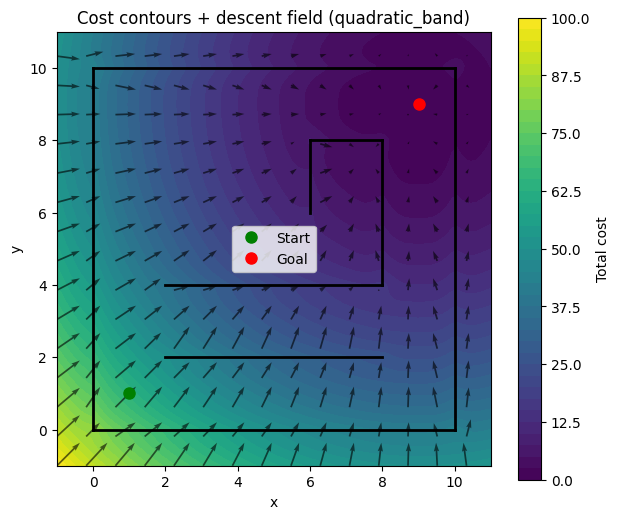

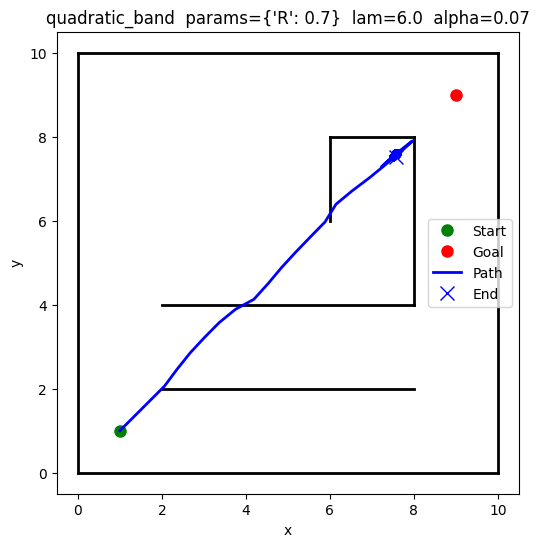

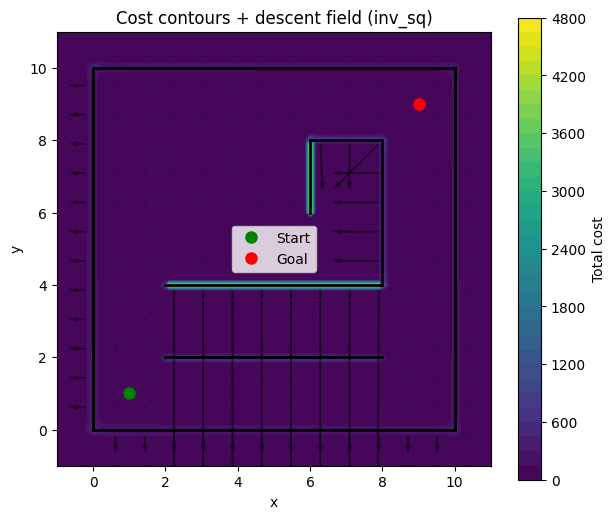

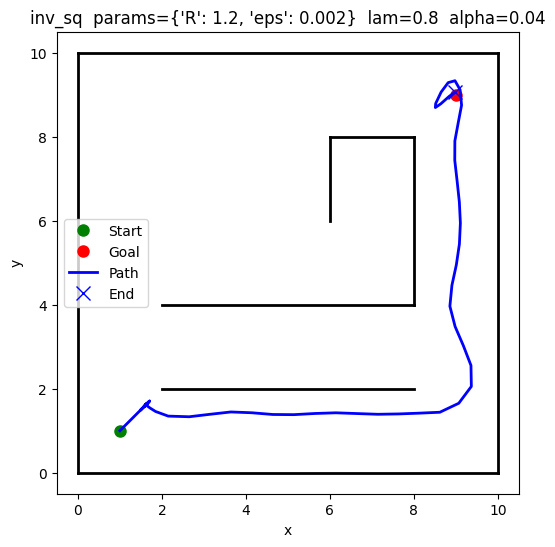

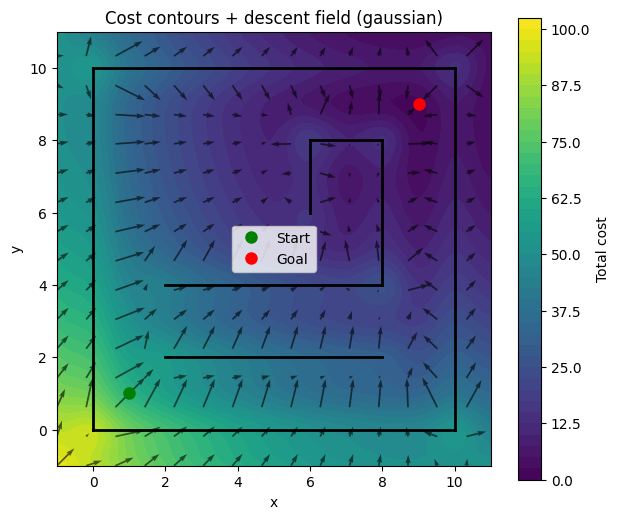

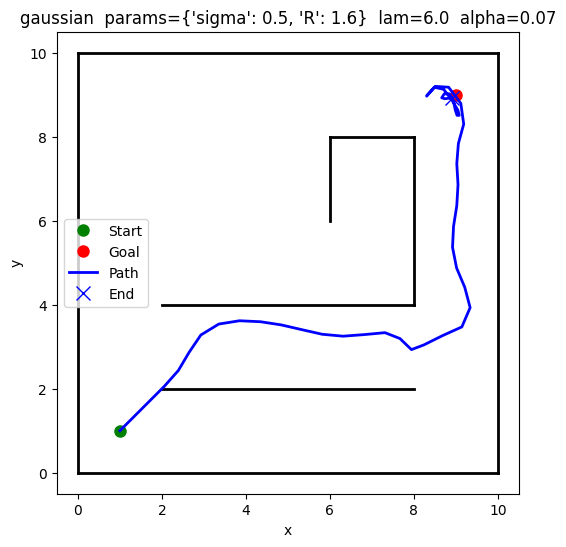

In [ ]:
# Visualize each result: cost+field and trajectory
for kind, (cfg, traj) in results.items():
    plot_cost_and_field(walls, start, goal, kind, cfg["params"], lam=cfg["lam"])
    plot_trajectory(
        walls, start, goal, traj,
        title=f"{kind}  params={cfg['params']}  lam={cfg['lam']}  alpha={cfg['alpha']}"
    )


### Animation example


In [ ]:
kind_to_animate = "gaussian"
params, traj = results[kind_to_animate]

anim = animate_trajectory(walls, start, goal, traj)

from IPython.display import HTML
HTML(anim.to_jshtml())



## 8) Qualitative discussion

The three wall penalty formulations produce noticeably different motion behavior even though they operate on the same floor plan and share the same start/goal configuration.

Influence radius / thickness.
Increasing the influence radius
𝑅
R (or Gaussian
𝜎
σ) effectively makes the walls feel “thicker.” The agent reacts to obstacles earlier and keeps a larger clearance. This produces smoother, wider arcs around walls but can also distort the path away from the straight-line route to the goal. When the radius is small, the trajectory hugs walls more tightly and behaves closer to an unconstrained straight-line descent, but risks entering narrow penalty spikes near corners. Large radii improve safety margins but increase the chance of shallow gradients that slow convergence.

Corner behavior.
Near corners, the quadratic band penalty tends to produce sharp gradient changes because its force activates only inside a fixed band. This can cause visible kinks or jitter as the agent repeatedly enters and exits the active region. The inverse-distance penalty creates stronger repulsion close to corners, which helps prevent penetration but may lead to abrupt turns. The Gaussian penalty is the smoothest: its gradient changes continuously, so corner navigation appears more fluid, though sometimes overly cautious.

Narrow corridors.
In tight passages, the quadratic band field can “center” the trajectory because both walls activate simultaneously with roughly symmetric forces. This creates a corridor-following effect. Inverse-distance penalties may cause the agent to hug one wall if gradients are slightly asymmetric, since the closer wall dominates the force. Gaussian penalties balance the two forces more gently, often producing smoother centering but slower progress due to weaker gradients.

Local minima.
Local minima arise when the wall repulsion cancels the goal attraction. The quadratic band formulation is most prone to trapping because its piecewise nature creates flat regions where gradients vanish. Inverse-distance penalties reduce this risk by maintaining strong gradients near walls, but they can still trap the agent in concave corners. Gaussian penalties are least likely to create hard traps because the field is smooth everywhere, but they can produce shallow basins that slow escape. These behaviors highlight the tradeoff between safety (strong wall avoidance) and navigability (maintaining a consistent descent direction toward the goal).
